In [1]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import sys; sys.path.insert(0, '../') #adds all the code we've written in src
from preprocessing import *

df = pd.read_csv("../../cyberbullying_tweets/cyberbullying_tweets.csv")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
tweets = df.tweet_text
tweets = remove_ats(tweets)
tweets = remove_emoji(tweets)
tweets = remove_special(tweets)
tweets = to_lowercase(tweets)
tweets = expand_contractions(tweets)
#tweets = remove_stopwords(tweets)
tweets = stem_series(tweets)
# tweets = lemmatize_series(tweets)

tweets

D:\capstone\src\notebooks\..\preprocessing.py:90: FutureWarning: The default value of regex will change from True to False in a future version.
  return text_arr.str.replace(at_regex, "")
D:\capstone\src\notebooks\..\preprocessing.py:97: FutureWarning: The default value of regex will change from True to False in a future version.
  return text_arr.str.replace(special_chars, "")


0        in other word katandandr your food wa crapilic...
1        whi is aussietv so white mkr theblock imaceleb...
2                 a classi whore or more red velvet cupcak
3        gio meh p thank for the head up but not too co...
4        thi is an isi account pretend to be a kurdish ...
                               ...                        
47687    black ppl are not expect to do anyth depend on...
47688    turner did not withhold hi disappoint turner c...
47689    i swear to god thi dumb nigger bitch i have go...
47690    yea fuck you rt if you are a nigger fuck unfol...
47691    bro you got to chill rt dog fuck kp that dumb ...
Name: tweet_text, Length: 47692, dtype: object

In [3]:
from sklearn.feature_extraction.text import CountVectorizer

def get_bow(text_arr, num_grams = 1): 
    """
    Returns the bag of words array for an array of preprocessed text. 
    
    params:
    -----------------------
    text_arr: pd.Series object of strings 
    
    return: 
    ----------------------
    numpy sparse matrix of of size n times m where n is the number 
    of text samples, and m is the number of words/n-grams in the corpus 
    """
    vectorizer = CountVectorizer(stop_words='english', ngram_range=(num_grams,num_grams))
    return vectorizer.fit_transform(text_arr)

X = get_bow(tweets)
X2 = get_bow(tweets, 2)

In [4]:
cat_dict = {}
for i, type in enumerate(df.cyberbullying_type.unique()):
    cat_dict[type] = i 
    
df["Y"] = df.cyberbullying_type.map(cat_dict)

In [5]:
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df.Y, test_size=0.2, random_state=42)

log_reg = LR(max_iter=10000, solver = 'saga').fit(X_train, y_train)

In [6]:
from sklearn.metrics import classification_report 
y_pred = log_reg.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.53      0.57      0.55      1512
           1       0.84      0.89      0.87      1446
           2       0.94      0.96      0.95      1530
           3       0.65      0.56      0.60      1870
           4       0.97      0.97      0.97      1612
           5       0.96      0.98      0.97      1569

    accuracy                           0.81      9539
   macro avg       0.82      0.82      0.82      9539
weighted avg       0.81      0.81      0.81      9539



In [34]:
from sklearn.decomposition import TruncatedSVD
reducer = TruncatedSVD(n_components=500).fit(X_train)

In [46]:
from sklearn.feature_extraction.text import TfidfTransformer as tfidf

def get_tfidf(text_arr, num_grams = 1): 
    """
    Returns the bag of words array for an array of preprocessed text. 
    
    params:
    -----------------------
    text_arr: pd.Series object of strings 
    
    return: 
    ----------------------
    numpy sparse matrix of of size n times m where n is the number 
    of text samples, and m is the number of words/n-grams in the corpus 
    """
    vectorizer = tfidf()
    return vectorizer.fit_transform(text_arr)

get_tfidf(X)
get_tfidf(X_train)

<38153x311416 sparse matrix of type '<class 'numpy.float64'>'
	with 425557 stored elements in Compressed Sparse Row format>

In [49]:
log_reg_lsa = LR(max_iter=10000, solver = 'saga').fit(get_tfidf(X_train), y_train)
y_pred = log_reg_lsa.predict(get_tfidf(X_test))

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.55      0.57      0.56      1586
           1       0.83      0.91      0.86      1393
           2       0.93      0.95      0.94      1546
           3       0.66      0.59      0.62      1825
           4       0.97      0.95      0.96      1626
           5       0.96      0.98      0.97      1563

    accuracy                           0.82      9539
   macro avg       0.82      0.82      0.82      9539
weighted avg       0.81      0.82      0.81      9539



In [37]:
from sklearn.feature_extraction.text import TfidfTransformer as tfidf
tf = tfidf().fit(X_train)
X_tf = tf.transform(X_train)
X_tf

<38153x311416 sparse matrix of type '<class 'numpy.float64'>'
	with 425557 stored elements in Compressed Sparse Row format>

In [38]:
tf_reducer = TruncatedSVD(n_components=500).fit(X_tf)

In [39]:
X_tf_lsa = tf_reducer.transform(X_tf)

In [40]:
log_reg_tf = LR(max_iter=10000, solver = 'saga').fit(X_tf_lsa, y_train)
y_pred = log_reg_tf.predict(tf_reducer.transform(tf.transform(X_test)))

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.79      0.36      0.49      3570
           1       0.57      0.96      0.72       905
           2       0.65      0.93      0.76      1099
           3       0.30      0.33      0.31      1441
           4       0.83      0.97      0.89      1373
           5       0.70      0.98      0.82      1151

    accuracy                           0.64      9539
   macro avg       0.64      0.75      0.67      9539
weighted avg       0.67      0.64      0.62      9539



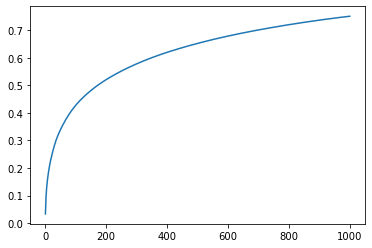

In [25]:
x = np.arange(1, 1001)
y = reducer.explained_variance_ratio_.cumsum()

plt.plot(x, y)

In [32]:
X_train_reduced = reducer.components_[:100,]
X_train_reduced.shape

(100, 41302)

In [31]:
X_train

<38153x41302 sparse matrix of type '<class 'numpy.int64'>'
	with 435431 stored elements in Compressed Sparse Row format>

In [7]:
def remove_special(text_arr: pd.Series) -> pd.Series:
    #  special_chars = '''`~|!|@|#|\$|\%|\^|\&|\*|\(|\)|-|+|-|=|\{|\}|\[|\]|\|\\|:|;|'|\<|\>|,|\.|\?|\/|\|\"|[0-9]'''
    special_chars = r"[^a-zA-Z\s]"
    return text_arr.str.replace(special_chars, "")

remove_special(df.tweet_text)

C:\Users\Ayush\AppData\Local\Temp/ipykernel_30284/3244443085.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  return text_arr.str.replace(special_chars, "")


0        In other words katandandre your food was crapi...
1        Why is aussietv so white MKR theblock ImACeleb...
2        XochitlSuckkks a classy whore Or more red velv...
3        JasonGio meh P  thanks for the heads up but no...
4        RudhoeEnglish This is an ISIS account pretendi...
                               ...                        
47687    Black ppl arent expected to do anything depend...
47688    Turner did not withhold his disappointment Tur...
47689    I swear to God This dumb nigger bitch I have g...
47690    Yea fuck you RT therealexel IF YOURE A NIGGER ...
47691    Bro U gotta chill RT CHILLShrammy Dog FUCK KP ...
Name: tweet_text, Length: 47692, dtype: object

In [4]:
import nltk

nltk_resources = ["punkt", "stopwords", "omw-1.4", "wordnet"]
for resource in nltk_resources:
    try:
        nltk.data.find("C:/Users/Ayush/AppData/Roaming/nltk_data/" + resource)
    except LookupError: 
        nltk.download(resource)
        

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ayush\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [16]:

def to_lower_pandas(text_arr):
    return text_arr.str.lower()

def to_lower_numpy(text_arr): 
    return text_arr.lower()

ModuleNotFoundError: No module named 'numpy.char'

In [17]:
tweets.dtype

dtype('O')

In [31]:
%%timeit 
remove_emoji(df.tweet_text)

172 ms ± 2.08 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [30]:
import re
def remove_emoji(text_arr: pd.Series) -> pd.Series:
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return text_arr.str.replace(emoji_pattern, "")

remove_emoji(df.tweet_text)

UsageError: Line magic function `%%timeit` not found.


In [33]:
import contractions

def expand_contractions(text_arr: pd.Series) -> pd.Series: 
    return text_arr.apply(contractions.fix)

expand_contractions(df.tweet_text)

0        In other words #katandandre, your food was cra...
1        Why is #aussietv so white? #MKR #theblock #ImA...
2        @XochitlSuckkks a classy whore? Or more red ve...
3        @Jason_Gio meh. :P  thanks for the heads up, b...
4        @RudhoeEnglish This is an ISIS account pretend...
                               ...                        
47687    Black ppl are not expected to do anything, dep...
47688    Turner did not withhold his disappointment. Tu...
47689    I swear to God. This dumb nigger bitch. I have...
47690    Yea fuck you RT @therealexel: IF YOU ARE A NIG...
47691    Bro. YOU got to chill RT @CHILLShrammy: Dog FU...
Name: tweet_text, Length: 47692, dtype: object

In [46]:
from nltk.stem import PorterStemmer

stem_series(df.tweet_text)

0        [in, other, word, #katandandre,, your, food, w...
1        [whi, is, #aussietv, so, white?, #mkr, #theblo...
2        [@xochitlsuckkk, a, classi, whore?, or, more, ...
3        [@jason_gio, meh., :p, thank, for, the, head, ...
4        [@rudhoeenglish, thi, is, an, isi, account, pr...
                               ...                        
47687    [black, ppl, aren't, expect, to, do, anything,...
47688    [turner, did, not, withhold, hi, disappointmen...
47689    [i, swear, to, god., thi, dumb, nigger, bitch....
47690    [yea, fuck, you, rt, @therealexel:, if, your, ...
47691    [bro., u, gotta, chill, rt, @chillshrammy:, do...
Name: tweet_text, Length: 47692, dtype: object